In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.cluster import AgglomerativeClustering

In [2]:
# dipendenza pacchetti xlrd e openpyxl
# così si crea un dizionario con tutti gli sheets
postCovid = pd.read_excel('20210408_postCovid.xlsx', sheet_name=None)

## Estrai_Tutto

In [3]:
ascvd_table = postCovid['Estrai_Tutto']

In [4]:
ascvd_table['DNASC'] = pd.to_datetime(ascvd_table['DNASC']) 

In [5]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [6]:
# calcolo tutte le età dei pazienti
ascvd_table['ETA']=ascvd_table["DNASC"].apply(calculate_age)

In [7]:
ascvd_table['ETA']

0      56
1      56
2      68
3      68
4      68
       ..
928    69
929    55
930    43
931    57
932    57
Name: ETA, Length: 933, dtype: int64

ascvd_table['ASCVD_Score'] = ascvd_table['ASCVD_Score'].astype(str)
ascvd_table['ASCVD_Score'] = ascvd_table['ASCVD_Score'].apply(lambda x: x.replace(',', '.'))
ascvd_table['ASCVD_Score'] = ascvd_table['ASCVD_Score'].astype(float)

In [8]:
# metto a -1 tutti quelli fuori dal range d'età, è corretto ?
ascvd_table.loc[(((ascvd_table['ETA']>79) | (40>ascvd_table['ETA'])) & (ascvd_table['ASCVD_Score'].notna())), 'ASCVD_Score'] = -1

In [9]:
ascvd_table = ascvd_table[['HDN_CODE', "Sesso", "ETA", 'DATA', 'ASCVD_Score']]

In [10]:
ascvd_table

HDN_CODE Sesso  ETA                 DATA ASCVD_Score
0       13034     M   56  10/07/2020 00:00:00         NaN
1       13034     M   56  18/12/2020 00:00:00     5,32000
2     3989181     M   68  10/07/2020 00:00:00         NaN
3     3989181     M   68  13/07/2020 00:00:00         NaN
4     3989181     M   68  23/02/2021 00:00:00         NaN
..        ...   ...  ...                  ...         ...
928   9088490     M   69  06/08/2020 00:00:00         NaN
929    175171     F   55  04/12/2020 00:00:00         NaN
930   9262359     M   43  01/12/2020 00:00:00         NaN
931   9427171     M   57  30/09/2020 00:00:00         NaN
932   9427171     M   57  02/10/2020 00:00:00     3,42000

[933 rows x 5 columns]

In [12]:
# rimuovo 10 righe raddoppiate che sono inutili
ascvd_table.drop_duplicates(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
ascvd_table.groupby(['HDN_CODE','DATA']).head()

HDN_CODE Sesso  ETA                 DATA ASCVD_Score
0       13034     M   56  10/07/2020 00:00:00         NaN
1       13034     M   56  18/12/2020 00:00:00     5,32000
2     3989181     M   68  10/07/2020 00:00:00         NaN
3     3989181     M   68  13/07/2020 00:00:00         NaN
4     3989181     M   68  23/02/2021 00:00:00         NaN
..        ...   ...  ...                  ...         ...
928   9088490     M   69  06/08/2020 00:00:00         NaN
929    175171     F   55  04/12/2020 00:00:00         NaN
930   9262359     M   43  01/12/2020 00:00:00         NaN
931   9427171     M   57  30/09/2020 00:00:00         NaN
932   9427171     M   57  02/10/2020 00:00:00     3,42000

[923 rows x 5 columns]

In [14]:
# correzione formato della data
ascvd_table['DATA'] = pd.to_datetime(ascvd_table['DATA'], format='%d/%m/%Y %H:%M:%S')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
ascvd_table.sort_values(['HDN_CODE','DATA']).head()

HDN_CODE Sesso  ETA       DATA ASCVD_Score
8       2236     M   64 2021-02-18         NaN
7       2236     M   64 2021-02-26    27,30000
6       6426     M   48 2021-04-02     2,56000
62      8377     M   57 2020-08-25         NaN
18      8377     M   57 2020-08-31     7,80000

In [16]:
ascvd_table_copy = ascvd_table.copy()
ascvd_table_copy['DATA_INT'] = ascvd_table['DATA'].astype("datetime64")
ascvd_table_copy['DATA_INT']=-ascvd_table['DATA'].rsub(pd.Timestamp('2020-01-01')).dt.days

9061288 1


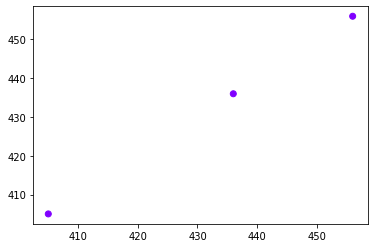

In [17]:
ptest=int(ascvd_table_copy.sample()["HDN_CODE"])
X=ascvd_table_copy[ascvd_table_copy["HDN_CODE"]==ptest]["DATA_INT"]
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=60, affinity='euclidean', linkage='complete')
cluster.fit_predict(X.values.reshape(-1, 1));
plt.scatter(X,X, c=cluster.labels_, cmap='rainbow')
print(str(ptest)+" "+str(cluster.n_clusters_))

In [18]:
for pat in ascvd_table_copy["HDN_CODE"].unique():
    X=ascvd_table_copy[ascvd_table_copy["HDN_CODE"]==pat]["DATA_INT"]
    if(X.size==1):
        ascvd_table_copy.loc[ascvd_table_copy["HDN_CODE"]==pat, "num_visita"] = 0
        continue
    cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=60, affinity='euclidean', linkage='complete')
    cluster.fit_predict(X.values.reshape(-1, 1));
    ascvd_table_copy.loc[ascvd_table_copy["HDN_CODE"]==pat, "num_visita"] = cluster.labels_

In [19]:
# le visite vengono raggruppate in base a quanto sono lontane, così posso tenere una solo riga
# per ogni gruppo di visite vicine e togliere quelle di troppo
ascvd_table_copy.sort_values(['HDN_CODE', 'DATA']).head()

HDN_CODE Sesso  ETA       DATA ASCVD_Score  DATA_INT  num_visita
8       2236     M   64 2021-02-18         NaN       414         0.0
7       2236     M   64 2021-02-26    27,30000       422         0.0
6       6426     M   48 2021-04-02     2,56000       457         0.0
62      8377     M   57 2020-08-25         NaN       237         0.0
18      8377     M   57 2020-08-31     7,80000       243         0.0

In [20]:
# qui ordino per codice, numero della visita e ascvd_score, così di tutti i giorni vicini alla
# visita posso tenere quelli che hanno un ascvd_score valido (nessuno viene cancellato)
# tra date vicine tolgo quelli con ascvd_score non nullo
ascvd_table_copy.sort_values(['HDN_CODE','num_visita','ASCVD_Score'], inplace=True)
ascvd_table_copy.drop_duplicates(subset=["HDN_CODE", "num_visita"], keep="first", inplace=True)

In [21]:
# ci sono 3 persone abbastanza distanziate che hanno 3 visite
ascvd_table_copy['num_visita'].value_counts()

0.0    459
1.0     89
2.0      3
Name: num_visita, dtype: int64

In [22]:
# stampa di tutti i medici
postCovid['Estrai_Tutto']['MEDICO'].value_counts()

Giovanni Guaraldi       433
Alessia Verduri         229
Bianca Beghè            157
Vittorio Iadisernia      35
Giovanni Dolci           22
Gabriella Orlando        18
Marianna Menozzi         15
Federica Carli           14
Pierluigi Donatelli       4
Rossella Fogliani         4
Margherita Digaetano      1
Elisabetta Rovatti        1
Name: MEDICO, dtype: int64

In [23]:
# 'Bianca Beghè', 'Alessia Verduri', 'Bianca Beghé', 'Beghé Bianca', 'Elisabetta Rovatti', 'Pierluigi Donatelli'

In [24]:
ascvd_table_copy.sort_values(['HDN_CODE', 'DATA'], inplace=True)

In [25]:
# ordinamento delle labels in maniera più logica
for pat in ascvd_table_copy["HDN_CODE"].unique():
    c = 0
    for ex in ascvd_table_copy[ascvd_table_copy["HDN_CODE"]==pat].iterrows():
        ascvd_table_copy.loc[((ascvd_table_copy["HDN_CODE"]==pat) & (ascvd_table_copy["DATA"]==ex[1]["DATA"])),"num_visita"] = c
        c += 1

In [26]:
ascvd_table_copy.head(20)

HDN_CODE Sesso  ETA                DATA ASCVD_Score  DATA_INT  num_visita
7       2236     M   64 2021-02-26 00:00:00    27,30000       422         0.0
6       6426     M   48 2021-04-02 00:00:00     2,56000       457         0.0
18      8377     M   57 2020-08-31 00:00:00     7,80000       243         0.0
51     11463     M   71 2020-08-31 00:00:00    24,74000       243         0.0
53     11463     M   71 2021-03-31 10:54:33         NaN       456         1.0
0      13034     M   56 2020-07-10 00:00:00         NaN       191         0.0
1      13034     M   56 2020-12-18 00:00:00     5,32000       352         1.0
63     15074     F   73 2020-11-19 00:00:00         NaN       323         0.0
15     15293     M   55 2020-07-10 00:00:00         NaN       191         0.0
16     15293     M   55 2021-02-24 00:00:00     5,70000       420         1.0
37     17030     M   56 2020-07-13 00:00:00         NaN       194         0.0
38     17030     M   56 2021-03-01 00:00:00     5,70000       425         1.0
33     23450     M   68 2020-07-08 00:00:00         NaN       189         0.0
88     26530     M   58 2020-09-30 00:00:00     9,31000       273         0.0
90     26530     M   58 2021-02-17 00:00:00         NaN       413         1.0
79     29798     M   60 2020-09-04 00:00:00         NaN       247         0.0
20     36003     F   65 2021-03-16 00:00:00    10,58000       440         0.0
30     38021     M   65 2020-08-07 00:00:00         NaN       219         0.0
32     38021     M   65 2021-02-16 00:00:00    10,04000       412         1.0
26     43763     M   73 2020-09-21 00:00:00    24,72000       264         0.0

## Table 1

In [27]:
charlson = postCovid['Table1']

In [28]:
charlson[['hdn_code', 'DataRilevazione', 'Charston_Totale']].groupby(['hdn_code'])['hdn_code'].count().value_counts()

1    317
2     17
3      1
Name: hdn_code, dtype: int64

In [29]:
# mettere le età già calcolate nella tabella
charlson=pd.merge(charlson,ascvd_table[["HDN_CODE","ETA",'DATA']].drop_duplicates(["HDN_CODE"]),left_on="hdn_code",right_on="HDN_CODE")

In [30]:
charlson.drop(columns=['HDN_CODE','Eta'], inplace=True)

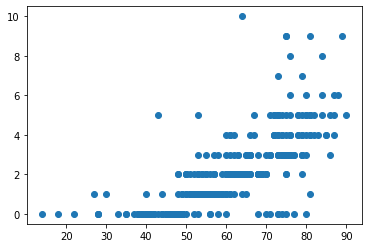

In [31]:
plt.scatter(charlson['ETA'], charlson['Charston_Totale'])

In [32]:
# tutti quelli che hanno almeno una colonna del charlson non nulla
copiacharlson = charlson[charlson.filter(regex='Charston.*').drop(columns=['Charston_Totale']).notna().any(1)].copy()

In [33]:
copiacharlson

Titolo  hdn_code      hdn_date  Admissioncode Altro  \
0    Anamnesi Patologica Remota   1116571  1.062188e+09            NaN   NaN   
1    Anamnesi Patologica Remota   1129826  1.062267e+09            NaN   NaN   
2    Anamnesi Patologica Remota     11463  1.062245e+09            NaN    No   
3    Anamnesi Patologica Remota   1170081  1.062392e+09            NaN   NaN   
4    Anamnesi Patologica Remota   1188309  1.062523e+09            NaN   NaN   
..                          ...       ...           ...            ...   ...   
349  Anamnesi Patologica Remota   9379636  1.062503e+09            NaN    No   
350  Anamnesi Patologica Remota   9415100  1.062247e+09            NaN   NaN   
351  Anamnesi Patologica Remota   9427171  1.062292e+09            NaN   NaN   
352  Anamnesi Patologica Remota   9427785  1.062277e+09            NaN   NaN   
353  Anamnesi Patologica Remota     97384  1.062362e+09            NaN   NaN   

            Altro_Note Charston_AIDS Charston_CardiopatiaIschemica  \
0                  NaN        0 = No                           NaN   
1                  NaN        0 = No                           NaN   
2                  NaN        0 = No                           NaN   
3                  NaN        0 = No                        0 = No   
4    Allergia ai FANS.        0 = No                        0 = No   
..                 ...           ...                           ...   
349                NaN        0 = No                        0 = No   
350                NaN        0 = No                           NaN   
351                NaN        0 = No                           NaN   
352                NaN        0 = No                           NaN   
353                NaN        0 = No                           NaN   

    Charston_Cerebrovascolari Charston_Connettivo  ...  \
0                      0 = No              0 = No  ...   
1                      0 = No              0 = No  ...   
2                      0 = No              0 = No  ...   
3                      0 = No              0 = No  ...   
4                      0 = No              0 = No  ...   
..                        ...                 ...  ...   
349                    0 = No              0 = No  ...   
350                    0 = No              0 = No  ...   
351                    0 = No              0 = No  ...   
352                    0 = No              0 = No  ...   
353                    0 = No              0 = No  ...   

    InsielRepartoRichiedente Ipertensione Ipertensione_Note Parkinson  \
0                        NaN           Si               NaN       NaN   
1                        NaN          NaN               NaN       NaN   
2                        NaN           Si               NaN       NaN   
3                        NaN          NaN               NaN       NaN   
4                        NaN           No               NaN        No   
..                       ...          ...               ...       ...   
349                      NaN           No               NaN        No   
350                      NaN          NaN               NaN       NaN   
351                      NaN          NaN               NaN       NaN   
352                      NaN          NaN               NaN       NaN   
353                      NaN          NaN               NaN       NaN   

    Parkinson_Note Sono_Presenti_Copatologie  ValidazioneData  \
0              NaN                        Si              NaN   
1              NaN                        Si              NaN   
2              NaN                        Si              NaN   
3              NaN                        No              NaN   
4              NaN                        No              NaN   
..             ...                       ...              ...   
349            NaN                        No              NaN   
350            NaN                        Si              NaN   
351            NaN                        Si              NaN   

In [34]:
def eta_to_charlson(eta):
    if eta < 50:
        return 0
    elif eta < 60:
        return 1
    elif eta < 70:
        return 2
    elif eta < 80:
        return 3
    else:
        return 4

In [35]:
# aggiungo una colonna con tutte le età calcolate con la funzione
copiacharlson.loc[:, 'Charlson_Eta_Calcolata'] = charlson['ETA'].apply(eta_to_charlson)

In [36]:
# nella colonna ricalcolata metto le età dove non c'eranote
copiacharlson.loc[charlson['Charston_Eta'].isna(), 'Charston_Totale_Ricalcolato'] = copiacharlson['Charston_Totale'].astype(int) + copiacharlson['Charlson_Eta_Calcolata'].astype(int)
copiacharlson.loc[charlson['Charston_Eta'].notna(), 'Charston_Totale_Ricalcolato'] = copiacharlson['Charston_Totale'].astype(int)

In [37]:
# i charlson calcolati differiscono da quelli inseriti solo per 22 persone
(copiacharlson['Charston_Totale_Ricalcolato'] - copiacharlson['Charston_Totale']).value_counts()

0.0    325
3.0      9
2.0      8
1.0      3
4.0      2
dtype: int64

In [38]:
copiacharlson

Titolo  hdn_code      hdn_date  Admissioncode Altro  \
0    Anamnesi Patologica Remota   1116571  1.062188e+09            NaN   NaN   
1    Anamnesi Patologica Remota   1129826  1.062267e+09            NaN   NaN   
2    Anamnesi Patologica Remota     11463  1.062245e+09            NaN    No   
3    Anamnesi Patologica Remota   1170081  1.062392e+09            NaN   NaN   
4    Anamnesi Patologica Remota   1188309  1.062523e+09            NaN   NaN   
..                          ...       ...           ...            ...   ...   
349  Anamnesi Patologica Remota   9379636  1.062503e+09            NaN    No   
350  Anamnesi Patologica Remota   9415100  1.062247e+09            NaN   NaN   
351  Anamnesi Patologica Remota   9427171  1.062292e+09            NaN   NaN   
352  Anamnesi Patologica Remota   9427785  1.062277e+09            NaN   NaN   
353  Anamnesi Patologica Remota     97384  1.062362e+09            NaN   NaN   

            Altro_Note Charston_AIDS Charston_CardiopatiaIschemica  \
0                  NaN        0 = No                           NaN   
1                  NaN        0 = No                           NaN   
2                  NaN        0 = No                           NaN   
3                  NaN        0 = No                        0 = No   
4    Allergia ai FANS.        0 = No                        0 = No   
..                 ...           ...                           ...   
349                NaN        0 = No                        0 = No   
350                NaN        0 = No                           NaN   
351                NaN        0 = No                           NaN   
352                NaN        0 = No                           NaN   
353                NaN        0 = No                           NaN   

    Charston_Cerebrovascolari Charston_Connettivo  ... Ipertensione_Note  \
0                      0 = No              0 = No  ...               NaN   
1                      0 = No              0 = No  ...               NaN   
2                      0 = No              0 = No  ...               NaN   
3                      0 = No              0 = No  ...               NaN   
4                      0 = No              0 = No  ...               NaN   
..                        ...                 ...  ...               ...   
349                    0 = No              0 = No  ...               NaN   
350                    0 = No              0 = No  ...               NaN   
351                    0 = No              0 = No  ...               NaN   
352                    0 = No              0 = No  ...               NaN   
353                    0 = No              0 = No  ...               NaN   

    Parkinson Parkinson_Note Sono_Presenti_Copatologie ValidazioneData  \
0         NaN            NaN                        Si             NaN   
1         NaN            NaN                        Si             NaN   
2         NaN            NaN                        Si             NaN   
3         NaN            NaN                        No             NaN   
4          No            NaN                        No             NaN   
..        ...            ...                       ...             ...   
349        No            NaN                        No             NaN   
350       NaN            NaN                        Si             NaN   
351       NaN            NaN                        Si             NaN   
352       NaN            NaN                        No             NaN   
353       NaN            NaN                        No             NaN   

    ValidazioneUtente  ETA       DATA Charlson_Eta_Calcolata  \
0                 NaN   54 2020-07-22                      1   
1                 NaN   79 2020-09-11                      3   
2                 NaN   71 2020-08-31                      3   
3                 NaN   45 2020-12-11                      0   
4                 NaN   50 2021-02-09                      1   
..                ...  ...        ...

In [39]:
# join delle tabelle con date più vicine di 45 giorni
# per ogni paziente, prendo il suo esame ripulito prima con ascvd,
# poi prendo il suo esame del charlson e se le date sono abbastanza vicine allora copio
# i valori che aveva nelle tabelle che sto unendo
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_charlson in copiacharlson[copiacharlson['hdn_code'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_charlson[1]['DataRilevazione'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Charlson_Totale'] = esame_charlson[1]['Charston_Totale']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Charlson_Diabete'] = esame_charlson[1]['Charston_Diabete']

## Table 2

In [40]:
stif = postCovid['Table2']

In [41]:
stif.drop(columns=['ETA'], inplace=True)

In [42]:
stif = pd.merge(stif, postCovid['Estrai_Tutto'][["HDN_CODE","ETA"]].drop_duplicates(["HDN_CODE"]), left_on='HDN_CODE', right_on='HDN_CODE')

In [43]:
# usiamo la funzione replace() di pandas con un dizionario ben definito
fibrosis_dict = {'F0-F1':1,
                 'F1-F2':2,
                 'F2-F3':3,
                 'F4':4}

In [44]:
stif['FRIBROSIS'].replace(fibrosis_dict, inplace=True)

In [45]:
steatosis_dict = {'S0':1,
                 'S1':2,
                 'S2':3,
                 'S3':4}

In [46]:
stif['STEATOSIS'].replace(steatosis_dict, inplace=True)

In [47]:
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_stifness in stif[stif['HDN_CODE'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_stifness[1]['DATA'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Stifness'] = esame_stifness[1]['Stifness']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'CAP'] = esame_stifness[1]['CAP']

In [48]:
ascvd_table_copy

HDN_CODE Sesso  ETA                DATA ASCVD_Score  DATA_INT  \
7        2236     M   64 2021-02-26 00:00:00    27,30000       422   
6        6426     M   48 2021-04-02 00:00:00     2,56000       457   
18       8377     M   57 2020-08-31 00:00:00     7,80000       243   
51      11463     M   71 2020-08-31 00:00:00    24,74000       243   
53      11463     M   71 2021-03-31 10:54:33         NaN       456   
..        ...   ...  ...                 ...         ...       ...   
914   9417013     M   45 2020-11-05 00:00:00         NaN       309   
932   9427171     M   57 2020-10-02 00:00:00     3,42000       275   
563   9427785     M   60 2020-09-22 00:00:00     9,44000       265   
610   9427785     M   60 2021-03-31 11:22:13         NaN       456   
611   9428914     F   67 2020-09-21 00:00:00         NaN       264   

     num_visita  Charlson_Totale Charlson_Diabete  Stifness    CAP  
7           0.0              NaN              NaN       6.7  167.0  
6           0.0              2.0           0 = No       NaN    NaN  
18          0.0              1.0           0 = No       NaN    NaN  
51          0.0              3.0           0 = No       NaN    NaN  
53          1.0              NaN              NaN       NaN    NaN  
..          ...              ...              ...       ...    ...  
914         0.0              NaN              NaN      16.5  239.0  
932         0.0              2.0           0 = No       NaN    NaN  
563         0.0              0.0           0 = No       NaN    NaN  
610         1.0              NaN              NaN       NaN    NaN  
611         0.0              NaN              NaN       NaN    NaN  

[551 rows x 11 columns]

In [49]:
ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == 9061288]

HDN_CODE Sesso  ETA       DATA ASCVD_Score  DATA_INT  num_visita  \
498   9061288     M   64 2021-03-12    12,19000       436         0.0   

     Charlson_Totale Charlson_Diabete  Stifness    CAP  
498              2.0           0 = No       7.0  282.0

## Table 3

In [50]:
frailty = postCovid['Table3']

In [51]:
frailty = pd.merge(frailty, postCovid['Estrai_Tutto'][["HDN_CODE"]].drop_duplicates(["HDN_CODE"]), left_on='hdn_code', right_on='HDN_CODE')

In [52]:
frailty = frailty.drop(columns=['hdn_code'])

In [53]:
frailty['FrailtyPhenotype']

0      2.0
1      1.0
2      3.0
3      2.0
4      NaN
      ... 
472    2.0
473    NaN
474    2.0
475    NaN
476    1.0
Name: FrailtyPhenotype, Length: 477, dtype: float64

In [54]:
# tolgo le persone che sono senza outcome
# prova = frailty.dropna(subset=['FrailtyPhenotype'])

In [55]:
frailty.loc[frailty['FrailtyPhenotype'] <=3, 'FrailtyPhenotypeBool'] = False
frailty.loc[frailty['FrailtyPhenotype'] >3, 'FrailtyPhenotypeBool'] = True

In [56]:
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_frailty in frailty[frailty['HDN_CODE'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_frailty[1]['DataRilevazione'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'FrailtyPhenotypeBool'] = esame_frailty[1]['FrailtyPhenotypeBool'] 

In [57]:
ascvd_table_copy

HDN_CODE Sesso  ETA                DATA ASCVD_Score  DATA_INT  \
7        2236     M   64 2021-02-26 00:00:00    27,30000       422   
6        6426     M   48 2021-04-02 00:00:00     2,56000       457   
18       8377     M   57 2020-08-31 00:00:00     7,80000       243   
51      11463     M   71 2020-08-31 00:00:00    24,74000       243   
53      11463     M   71 2021-03-31 10:54:33         NaN       456   
..        ...   ...  ...                 ...         ...       ...   
914   9417013     M   45 2020-11-05 00:00:00         NaN       309   
932   9427171     M   57 2020-10-02 00:00:00     3,42000       275   
563   9427785     M   60 2020-09-22 00:00:00     9,44000       265   
610   9427785     M   60 2021-03-31 11:22:13         NaN       456   
611   9428914     F   67 2020-09-21 00:00:00         NaN       264   

     num_visita  Charlson_Totale Charlson_Diabete  Stifness    CAP  \
7           0.0              NaN              NaN       6.7  167.0   
6           0.0              2.0           0 = No       NaN    NaN   
18          0.0              1.0           0 = No       NaN    NaN   
51          0.0              3.0           0 = No       NaN    NaN   
53          1.0              NaN              NaN       NaN    NaN   
..          ...              ...              ...       ...    ...   
914         0.0              NaN              NaN      16.5  239.0   
932         0.0              2.0           0 = No       NaN    NaN   
563         0.0              0.0           0 = No       NaN    NaN   
610         1.0              NaN              NaN       NaN    NaN   
611         0.0              NaN              NaN       NaN    NaN   

    FrailtyPhenotypeBool  
7                  False  
6                   True  
18                   NaN  
51                   NaN  
53                 False  
..                   ...  
914                False  
932                  NaN  
563                  NaN  
610                False  
611                  NaN  

[551 rows x 12 columns]

## Table 4

In [58]:
pneumo = postCovid['Table4']

In [59]:
# tolgo il campo ETA duplicato
pneumo.drop(columns=['ETA'], inplace=True)

In [60]:
pneumo = pd.merge(pneumo, postCovid['Estrai_Tutto'][["HDN_CODE","ETA"]].drop_duplicates(["HDN_CODE"]), left_on='hdn_code', right_on='HDN_CODE')

In [61]:
# tolgo hdn_code duplicato
pneumo.drop(columns=['hdn_code'], inplace=True)

In [62]:
#prima trasformo tutto in stringa, converto e torno in float
pneumo['EGA_HB'] = pneumo['EGA_HB'].astype(str)
pneumo['EGA_HB'] = pneumo['EGA_HB'].apply(lambda x: x.replace(',', '.'))
pneumo['EGA_HB'] = pneumo['EGA_HB'].astype(float)

In [63]:
#prima trasformo tutto in stringa, converto e torno in float
pneumo['EGA_PaCO2'] = pneumo['EGA_PaCO2'].astype(str)
pneumo['EGA_PaCO2'] = pneumo['EGA_PaCO2'].apply(lambda x: x.replace(',', '.'))
pneumo['EGA_PaCO2'] = pneumo['EGA_PaCO2'].astype(float)

In [64]:
#prima trasformo tutto in stringa, converto e torno in float
pneumo['EGA_PaO2'] = pneumo['EGA_PaO2'].astype(str)
pneumo['EGA_PaO2'] = pneumo['EGA_PaO2'].apply(lambda x: x.replace(',', '.'))
pneumo['EGA_PaO2'] = pneumo['EGA_PaO2'].astype(float)

In [65]:
# modifico il file a riga 247 per valore "7.4314.9"
# prima trasformo tutto in stringa, converto e torno in float
pneumo['EGA_PH'] = pneumo['EGA_PH'].astype(str)
pneumo['EGA_PH'] = pneumo['EGA_PH'].apply(lambda x: x.replace(',', '.'))
pneumo['EGA_PH'] = pneumo['EGA_PH'].astype(float)

In [66]:
pneumo.loc[pneumo['EGA_PH'] > 14, 'EGA_PH'] = np.nan

In [67]:
# prima trasformo tutto in stringa, converto e torno in float
pneumo['EGA_SatO2'] = pneumo['EGA_SatO2'].astype(str)
pneumo['EGA_SatO2'] = pneumo['EGA_SatO2'].apply(lambda x: x.replace(',', '.'))
pneumo['EGA_SatO2'] = pneumo['EGA_SatO2'].astype(float)

In [68]:
pneumo.loc[pneumo['EGA_SatO2'] < 30, 'EGA_SatO2'] = np.nan

In [69]:
pneumo['Pneumo_ProveFunzResp_FEV_FVCPre'] = pneumo['Pneumo_ProveFunzResp_FEV_FVCPre'].astype(str)
pneumo['Pneumo_ProveFunzResp_FEV_FVCPre'] = pneumo['Pneumo_ProveFunzResp_FEV_FVCPre'].apply(lambda x: x.replace(',', '.'))
pneumo['Pneumo_ProveFunzResp_FEV_FVCPre'] = pneumo['Pneumo_ProveFunzResp_FEV_FVCPre'].astype(float)

In [70]:
pneumo['Pneumo_ProveFunzResp_MEP'] = pneumo['Pneumo_ProveFunzResp_MEP'].astype(str)
pneumo['Pneumo_ProveFunzResp_MEP'] = pneumo['Pneumo_ProveFunzResp_MEP'].apply(lambda x: x.replace(',', '.'))
pneumo['Pneumo_ProveFunzResp_MEP'].replace('na', np.nan, inplace=True);
pneumo['Pneumo_ProveFunzResp_MEP'].replace('n', '',inplace=True)
pneumo['Pneumo_ProveFunzResp_MEP'] = pneumo['Pneumo_ProveFunzResp_MEP'].astype(float)

In [71]:
pneumo['Pneumo_ProveFunzResp_MIP'] = pneumo['Pneumo_ProveFunzResp_MIP'].astype(str)
pneumo['Pneumo_ProveFunzResp_MIP'] = pneumo['Pneumo_ProveFunzResp_MIP'].apply(lambda x: x.replace(',', '.'))
pneumo['Pneumo_ProveFunzResp_MIP'] = pneumo['Pneumo_ProveFunzResp_MIP'].astype(float)

In [72]:
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_pneumo in pneumo[pneumo['HDN_CODE'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_pneumo[1]['DATA'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'EGA_HB'] = esame_pneumo[1]['EGA_HB']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'EGA_PaO2'] = esame_pneumo[1]['EGA_PaO2']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'EGA_SatO2'] = esame_pneumo[1]['EGA_SatO2']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Pneumo_ProveFunzResp_FEV_FVCPre'] = esame_pneumo[1]['Pneumo_ProveFunzResp_FEV_FVCPre']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Pneumo_ProveFunzResp_MEP'] = esame_pneumo[1]['Pneumo_ProveFunzResp_MEP']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Pneumo_ProveFunzResp_MIP'] = esame_pneumo[1]['Pneumo_ProveFunzResp_MIP']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Pneumo_ScalaBorg'] = esame_pneumo[1]['Pneumo_ScalaBorg']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'TestCammino6Min_BorgBase'] = esame_pneumo[1]['TestCammino6Min_BorgBase']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'TestCammino6Min_BorgEnd'] = esame_pneumo[1]['TestCammino6Min_BorgEnd']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'TestCammino6Min_Distanza'] = esame_pneumo[1]['TestCammino6Min_Distanza']
                

In [73]:
ascvd_table_copy

HDN_CODE Sesso  ETA                DATA ASCVD_Score  DATA_INT  \
7        2236     M   64 2021-02-26 00:00:00    27,30000       422   
6        6426     M   48 2021-04-02 00:00:00     2,56000       457   
18       8377     M   57 2020-08-31 00:00:00     7,80000       243   
51      11463     M   71 2020-08-31 00:00:00    24,74000       243   
53      11463     M   71 2021-03-31 10:54:33         NaN       456   
..        ...   ...  ...                 ...         ...       ...   
914   9417013     M   45 2020-11-05 00:00:00         NaN       309   
932   9427171     M   57 2020-10-02 00:00:00     3,42000       275   
563   9427785     M   60 2020-09-22 00:00:00     9,44000       265   
610   9427785     M   60 2021-03-31 11:22:13         NaN       456   
611   9428914     F   67 2020-09-21 00:00:00         NaN       264   

     num_visita  Charlson_Totale Charlson_Diabete  Stifness  ...  EGA_HB  \
7           0.0              NaN              NaN       6.7  ...    15.6   
6           0.0              2.0           0 = No       NaN  ...     NaN   
18          0.0              1.0           0 = No       NaN  ...     NaN   
51          0.0              3.0           0 = No       NaN  ...    14.8   
53          1.0              NaN              NaN       NaN  ...     NaN   
..          ...              ...              ...       ...  ...     ...   
914         0.0              NaN              NaN      16.5  ...    11.5   
932         0.0              2.0           0 = No       NaN  ...    12.5   
563         0.0              0.0           0 = No       NaN  ...    14.0   
610         1.0              NaN              NaN       NaN  ...     NaN   
611         0.0              NaN              NaN       NaN  ...     NaN   

    EGA_PaO2  EGA_SatO2  Pneumo_ProveFunzResp_FEV_FVCPre  \
7       77.6       96.6                            83.90   
6        NaN        NaN                              NaN   
18       NaN        NaN                              NaN   
51      82.0       96.0                            90.00   
53       NaN        NaN                              NaN   
..       ...        ...                              ...   
914     94.9       98.2                            74.97   
932     75.7       97.1                            85.60   
563     94.0       97.2                            75.60   
610      NaN        NaN                              NaN   
611      NaN        NaN                              NaN   

     Pneumo_ProveFunzResp_MEP  Pneumo_ProveFunzResp_MIP  Pneumo_ScalaBorg  \
7                        98.0                     105.0   1 - molto lieve   
6                         NaN                       NaN               NaN   
18                        NaN                       NaN               NaN   
51                        NaN                       NaN       0 - nessuna   
53                        NaN                       NaN               NaN   
..                        ...                       ...               ...   
914                      44.0                      38.0   1 - molto lieve   
932                       NaN                       NaN   1 - molto lieve   
563                       NaN                       NaN       0 - nessuna   
610                       NaN                       NaN               NaN   
611                       NaN                       NaN               NaN   

     TestCammino6Min_BorgBase TestCammino6Min_BorgEnd TestCammino6Min_Distanza  
7                 0 - nessuna         1 - molto lieve                    520.0  
6                         NaN                     NaN                      NaN  
18                        NaN                     NaN                      NaN  
51                0 - nessuna             0 - nessuna                    440.0  
53                        NaN                     NaN                      NaN  
..                        ...                     ...                      ...  
914               0 - nessuna         

## Table 6

In [74]:
valori = postCovid['Table6']

In [75]:
valori = pd.merge(valori, postCovid['Estrai_Tutto'][["HDN_CODE"]].drop_duplicates(["HDN_CODE"]), left_on='hdn_code', right_on='HDN_CODE')

In [76]:
valori.drop(columns=['hdn_code'], inplace=True)

In [77]:
# pulizia categorica dei valori di alcool
valori.loc[valori['Alcool'] == "0",'Alcool'] = False
valori.loc[valori['Alcool'].str.contains("(?i)mai")==True,'Alcool'] = False
valori.loc[valori['Alcool'].str.contains("(?i)no")==True,'Alcool'] = False
valori.loc[valori['Alcool'].str.contains("(?i)nessuno")==True,'Alcool'] = False
valori.loc[(valori['Alcool'] != False) & (valori['Alcool'].notna()), 'Alcool'] = True

In [78]:
# i valori di peso sono da trasformare in float
valori['Peso'] = valori['Peso'].astype(str)
valori['Peso'] = valori['Peso'].apply(lambda x: x.replace(',', '.'))
valori['Peso'] = valori['Peso'].astype(float)

In [79]:
# tolgo i valori inutili da qui
valori['PesoPostRicovero'].replace('non sa', None, inplace=True)

In [80]:
valori['PesoPostRicovero'] = valori['PesoPostRicovero'].astype(str)
valori['PesoPostRicovero'] = valori['PesoPostRicovero'].apply(lambda x: x.replace(',', '.'))
valori['PesoPostRicovero'] = valori['PesoPostRicovero'].astype(float)

In [81]:
valori['PesoPreRicovero'].replace('non sa', None, inplace=True)
valori['PesoPreRicovero'] = valori['PesoPreRicovero'].astype(str)
valori['PesoPreRicovero'] = valori['PesoPreRicovero'].apply(lambda x: x.replace(',', '.'))
valori['PesoPreRicovero'] = valori['PesoPreRicovero'].astype(float)

In [82]:
# tolgo i valori inutili da qui
valori['PesoPreRicovero'].replace('non sa', None, inplace=True)

In [83]:
valori['Dispnea'].replace({'Si':1, 'No':0}, inplace=True)

In [84]:
valori['Fumatore'].replace({'No':0,
                            'Ex fumatore':1,
                            'Si':2}, inplace=True)

In [85]:
valori.loc[valori['Fumatore']<=1,'Fumatore'] = False

In [86]:
valori.loc[valori['Fumatore']==2,'Fumatore'] = True

In [87]:
# sopra i 100 respiri al minuto è difficile arrivare
valori.loc[valori['Frequenza_Respiratoria'] > 100, 'Frequenza_Respiratoria'] = np.nan

In [88]:
valori['Sintomi_Cadute'].replace({'Si':True, 'No':False}, inplace=True)

In [89]:
valori['Sintomi_DifficoltaDeglutizione'].replace({'Si':True, 'No':False}, inplace=True)

In [90]:
valori['Sintomi_DistUdito'].replace({'Si':True, 'No':False}, inplace=True)

In [91]:
valori['Sintomi_DistVista'].replace({'Si':True, 'No':False}, inplace=True)

In [92]:
valori['SintomiNeuropsico_Ageusia'].replace({'Si':True, 'No':False}, inplace=True)

In [93]:
valori['SintomiNeuropsico_Anosmia'].replace({'Si':True, 'No':False}, inplace=True)

In [94]:
valori['SintomiNeuropsico_Astenia'].replace({'Si':True, 'No':False}, inplace=True)

In [95]:
valori['SintomiNeuropsico_CognitivoAttenzione'].replace({'Si':True, 'No':False}, inplace=True)

In [96]:
valori['SintomiNeuropsico_CognitivoConcentrazione'].replace({'Si':True, 'No':False}, inplace=True)

In [97]:
valori['SintomiNeuropsico_CognitivoMemoria'].replace({'Si':True, 'No':False}, inplace=True)

In [98]:
valori['SintomiNeuropsico_DistEquilibrio'].replace({'Si':True, 'No':False}, inplace=True)

In [99]:
valori['SintomiNeuropsico_DistSonno'].replace({'Si':True, 'No':False}, inplace=True)

In [100]:
valori['SintomiNeuropsico_DoloriMuscolari'].replace({'Si':True, 'No':False}, inplace=True)

In [101]:
valori['SintomiNeuropsico_Effluvium'].replace({'Si':True, 'No':False}, inplace=True)

In [102]:
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_valori in valori[valori['HDN_CODE'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_valori[1]['DataRilevazione'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Alcool'] = esame_valori[1]['Alcool']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'BMI'] = esame_valori[1]['BMI']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'BMI_Ricovero'] = esame_valori[1]['BMI_Ricovero']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'BMIPostRicovero'] = esame_valori[1]['BMIPostRicovero']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Fumatore'] = esame_valori[1]['Fumatore']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Pack_years'] = esame_valori[1]['Pack_years']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Sintomi_Cadute'] = esame_valori[1]['Sintomi_Cadute']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Sintomi_DifficoltaDeglutizione'] = esame_valori[1]['Sintomi_DifficoltaDeglutizione']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Sintomi_DistUdito'] = esame_valori[1]['Sintomi_DistUdito']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Sintomi_DistVista'] = esame_valori[1]['Sintomi_DistVista']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_Ageusia'] = esame_valori[1]['SintomiNeuropsico_Ageusia']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_Anosmia'] = esame_valori[1]['SintomiNeuropsico_Anosmia']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_Astenia'] = esame_valori[1]['SintomiNeuropsico_Astenia']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_CognitivoAttenzione'] = esame_valori[1]['SintomiNeuropsico_CognitivoAttenzione']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_CognitivoConcentrazione'] = esame_valori[1]['SintomiNeuropsico_CognitivoConcentrazione']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_CognitivoMemoria'] = esame_valori[1]['SintomiNeuropsico_CognitivoMemoria']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_DistEquilibrio'] = esame_valori[1]['SintomiNeuropsico_DistEquilibrio']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_DistSonno'] = esame_valori[1]['SintomiNeuropsico_DistSonno']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_DoloriMuscolari'] = esame_valori[1]['SintomiNeuropsico_DoloriMuscolari']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SintomiNeuropsico_Effluvium'] = esame_valori[1]['SintomiNeuropsico_Effluvium']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'VitaCm'] = esame_valori[1]['VitaCm']

In [103]:
ascvd_table_copy

HDN_CODE Sesso  ETA                DATA ASCVD_Score  DATA_INT  \
7        2236     M   64 2021-02-26 00:00:00    27,30000       422   
6        6426     M   48 2021-04-02 00:00:00     2,56000       457   
18       8377     M   57 2020-08-31 00:00:00     7,80000       243   
51      11463     M   71 2020-08-31 00:00:00    24,74000       243   
53      11463     M   71 2021-03-31 10:54:33         NaN       456   
..        ...   ...  ...                 ...         ...       ...   
914   9417013     M   45 2020-11-05 00:00:00         NaN       309   
932   9427171     M   57 2020-10-02 00:00:00     3,42000       275   
563   9427785     M   60 2020-09-22 00:00:00     9,44000       265   
610   9427785     M   60 2021-03-31 11:22:13         NaN       456   
611   9428914     F   67 2020-09-21 00:00:00         NaN       264   

     num_visita  Charlson_Totale Charlson_Diabete  Stifness  ...  \
7           0.0              NaN              NaN       6.7  ...   
6           0.0              2.0           0 = No       NaN  ...   
18          0.0              1.0           0 = No       NaN  ...   
51          0.0              3.0           0 = No       NaN  ...   
53          1.0              NaN              NaN       NaN  ...   
..          ...              ...              ...       ...  ...   
914         0.0              NaN              NaN      16.5  ...   
932         0.0              2.0           0 = No       NaN  ...   
563         0.0              0.0           0 = No       NaN  ...   
610         1.0              NaN              NaN       NaN  ...   
611         0.0              NaN              NaN       NaN  ...   

     SintomiNeuropsico_Anosmia SintomiNeuropsico_Astenia  \
7                        False                     False   
6                        False                     False   
18                       False                      True   
51                       False                     False   
53                         NaN                       NaN   
..                         ...                       ...   
914                      False                     False   
932                      False                      True   
563                      False                     False   
610                        NaN                       NaN   
611                        NaN                       NaN   

     SintomiNeuropsico_CognitivoAttenzione  \
7                                    False   
6                                    False   
18                                   False   
51                                   False   
53                                     NaN   
..                                     ...   
914                                  False   
932                                   True   
563                                  False   
610                                    NaN   
611                                    NaN   

     SintomiNeuropsico_CognitivoConcentrazione  \
7                                        False   
6                                        False   
18                                       False   
51                                       False   
53                                         NaN   
..                                         ...   
914                                      False   
932                                       True   
563                                      False   
610                                        NaN   
611                                        NaN   

     SintomiNeuropsico_CognitivoMemoria  SintomiNeuropsico_DistEquilibrio  \
7                                 False                             False   
6                                 False                             False   
18                                False                             False   
51                                False                             False   
53                                  NaN                               NaN   
..        

# Table 9

In [104]:
nutr = postCovid['Table9']

In [105]:
nutr = pd.merge(nutr, postCovid['Estrai_Tutto'][["HDN_CODE"]].drop_duplicates(["HDN_CODE"]), left_on='hdn_code', right_on='HDN_CODE')

In [106]:
nutr.drop(columns=['hdn_code'], inplace=True)

In [107]:
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_nutr in nutr[nutr['HDN_CODE'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_nutr[1]['DATA'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'CALORIE'] = esame_nutr[1]['CALORIE']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'PROTEINE_Perc'] = esame_nutr[1]['PROTEINE_Perc']

## Table 10

In [108]:
cog = postCovid['Table10']

In [109]:
cog = pd.merge(cog, postCovid['Estrai_Tutto'][["HDN_CODE"]].drop_duplicates(["HDN_CODE"]), left_on='hdn_code', right_on='HDN_CODE')

In [110]:
cog.drop(columns=['hdn_code'], inplace=True)

In [111]:
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_cog in cog[cog['HDN_CODE'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_cog[1]['DATA'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'CogStateScore_Esito'] = esame_cog[1]['CogStateScore_Esito']

In [112]:
ascvd_table_copy

HDN_CODE Sesso  ETA                DATA ASCVD_Score  DATA_INT  \
7        2236     M   64 2021-02-26 00:00:00    27,30000       422   
6        6426     M   48 2021-04-02 00:00:00     2,56000       457   
18       8377     M   57 2020-08-31 00:00:00     7,80000       243   
51      11463     M   71 2020-08-31 00:00:00    24,74000       243   
53      11463     M   71 2021-03-31 10:54:33         NaN       456   
..        ...   ...  ...                 ...         ...       ...   
914   9417013     M   45 2020-11-05 00:00:00         NaN       309   
932   9427171     M   57 2020-10-02 00:00:00     3,42000       275   
563   9427785     M   60 2020-09-22 00:00:00     9,44000       265   
610   9427785     M   60 2021-03-31 11:22:13         NaN       456   
611   9428914     F   67 2020-09-21 00:00:00         NaN       264   

     num_visita  Charlson_Totale Charlson_Diabete  Stifness  ...  \
7           0.0              NaN              NaN       6.7  ...   
6           0.0              2.0           0 = No       NaN  ...   
18          0.0              1.0           0 = No       NaN  ...   
51          0.0              3.0           0 = No       NaN  ...   
53          1.0              NaN              NaN       NaN  ...   
..          ...              ...              ...       ...  ...   
914         0.0              NaN              NaN      16.5  ...   
932         0.0              2.0           0 = No       NaN  ...   
563         0.0              0.0           0 = No       NaN  ...   
610         1.0              NaN              NaN       NaN  ...   
611         0.0              NaN              NaN       NaN  ...   

     SintomiNeuropsico_CognitivoConcentrazione  \
7                                        False   
6                                        False   
18                                       False   
51                                       False   
53                                         NaN   
..                                         ...   
914                                      False   
932                                       True   
563                                      False   
610                                        NaN   
611                                        NaN   

    SintomiNeuropsico_CognitivoMemoria  SintomiNeuropsico_DistEquilibrio  \
7                                False                             False   
6                                False                             False   
18                               False                             False   
51                               False                             False   
53                                 NaN                               NaN   
..                                 ...                               ...   
914                              False                             False   
932                               True                             False   
563                              False                             False   
610                                NaN                               NaN   
611                                NaN                               NaN   

     SintomiNeuropsico_DistSonno  SintomiNeuropsico_DoloriMuscolari  \
7                          False                              False   
6                           True                              False   
18                         False                              False   
51                         False                              False   
53                           NaN                                NaN   
..                           ...                                ...   
914                        False                              False   
932                         True                              False   
563                        False                              False   
610                          NaN                                NaN   
611                          NaN                    

## Table 11

In [113]:
analisi = postCovid["Table11"]

In [114]:
analisi = pd.merge(analisi, postCovid['Estrai_Tutto'][["HDN_CODE",'ETA','DATA']].drop_duplicates(["HDN_CODE"]), left_on='hdn_code', right_on='HDN_CODE')

In [115]:
analisi.drop(columns='hdn_code', inplace=True)

In [116]:
# tolgo tutti i duplicati esattamente uguali
analisi.drop_duplicates(inplace=True)

In [117]:
# tolgo gli orari a tutte le date, dicendogli da che formato prendere l'ordine
analisi['DataRef'] = pd.to_datetime(analisi['DataRef'], format="%d/%m/%Y %H:%M:%S")
analisi.sort_values(by=['HDN_CODE', 'DataRef'], inplace=True)
analisi['DataRef'] = pd.to_datetime(analisi['DataRef'], format="%d/%m/%Y %H:%M:%S").dt.date.astype("datetime64")

In [118]:
# altrimenti si usa la funzione pd.to_numeric(df, errors='coerce')

In [119]:
analisi['GlobuliBianchi'] = pd.to_numeric(analisi['GlobuliBianchi'], errors='coerce')

In [120]:
# ci sono valori distribuiti molto male
analisi[analisi['GlobuliBianchi'] > 100000000]

Titolo    DataRef  Emoglobina GlobuliRossi  GlobuliBianchi  Linfociti  \
10069  Esami 2020-04-22         9.9         3.51    4.630000e+09        9.7   
10085  Esami 2020-04-29         9.6         3.49    4.370000e+09        0.0   

       Linfociti_Assoluti  Neutrofili Med_Neutrofili_perc  Ematocrito  ...  \
10069               450.0        3.96                85.5        30.1  ...   
10085               570.0        3.49                79.9        30.5  ...   

       uUrobilinogeno  uUrobilinogeno_Note ValidazioneData  ValidazioneUtente  \
10069             NaN                  NaN             NaN                NaN   
10085             NaN                  NaN             NaN                NaN   

      VersioneReferto VES  VES_Note HDN_CODE  ETA                 DATA  
10069               2 NaN       NaN  4384796   73  13/11/2020 00:00:00  
10085               1 NaN       NaN  4384796   73  13/11/2020 00:00:00  

[2 rows x 172 columns]

In [121]:
analisi.loc[analisi['GlobuliBianchi_Note'] == '1', 'GlobuliBianchi'] = analisi['GlobuliBianchi'] / 1000

In [122]:
# cancello tutti quelli sopra a 150
analisi.loc[analisi['GlobuliBianchi'] > 150, 'GlobuliBianchi'] = np.nan

In [123]:
analisi['Linfociti'] = analisi['Linfociti'] * 1000

In [124]:
analisi.loc[(analisi['Linfociti_Assoluti'].isnull()), 'Linfociti_Assoluti'] = analisi['Linfociti']

In [125]:
analisi.drop(columns=['Linfociti'], inplace=True)

In [126]:
# ci sono unità di misura diverse e vanno riunite
analisi.loc[analisi['Neutrofili_Note']=='calcolato', 'Neutrofili'] = analisi['Neutrofili'] / 1000

In [127]:
# metto un valore di default (da chiedere se va bene)
analisi['D_dimero'].replace('> 40.000', 40000, inplace = True)

In [128]:
analisi['D_dimero'] = analisi['D_dimero'].astype(float)

In [129]:
# metto un valore di default
analisi['Interleuchina6'].replace({ 'esame non eseguito':np.nan,
                                    '>2300':'2300',
                                    '> 2300':'2300'}, inplace = True)
analisi['Interleuchina6'] = analisi['Interleuchina6'].astype(str)
analisi['Interleuchina6'] = analisi['Interleuchina6'].apply(lambda x: x.replace(',', '.'))
analisi['Interleuchina6'] = analisi['Interleuchina6'].astype(float)

In [130]:
analisi.loc[analisi['Interleuchina6']>2300, 'Interleuchina6'] = 2300

In [131]:
analisi['PCR'].replace({'<0.2':'0.2',
                        '< 0.2':'0.2'}, inplace = True)
analisi['PCR'] = analisi['PCR'].astype(str)
analisi['PCR'] = analisi['PCR'].apply(lambda x: x.replace(',', '.'))
analisi['PCR'] = analisi['PCR'].astype(float)

In [132]:
#analisi.loc[analisi['GPT_ALT'] == '<5', 'GPT_ALT'] = np.nan

In [133]:
# metto un valore default
analisi['GPT_ALT'].replace('<5', '5', inplace=True)

In [134]:
analisi['GPT_ALT'] = analisi['GPT_ALT'].astype(float)

In [135]:
analisi['Glicemia'] = analisi['Glicemia'].astype(str)
# analisi.loc[analisi['Glicemia']=='<20','Glicemia'] = np.nan
analisi.loc[analisi['Glicemia']=='<20','Glicemia'] = 20
analisi['Glicemia'] = analisi['Glicemia'].astype(float)

In [136]:
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_sangue in analisi[analisi['HDN_CODE'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_sangue[1]['DataRef'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'GlobuliBianchi'] = esame_sangue[1]['GlobuliBianchi']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Linfociti_Assoluti'] = esame_sangue[1]['Linfociti_Assoluti']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Neutrofili'] = esame_sangue[1]['Neutrofili']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Piastrine'] = esame_sangue[1]['Piastrine']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'GPT_ALT'] = esame_sangue[1]['GPT_ALT']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'D_dimero'] = esame_sangue[1]['D_dimero']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Fibrinogeno'] = esame_sangue[1]['Fibrinogeno']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Glicemia'] = esame_sangue[1]['Glicemia']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'INSULINA'] = esame_sangue[1]['INSULINA']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'PCR'] = esame_sangue[1]['PCR']

## Table 13

In [137]:
ricovero = postCovid['Table13']

In [138]:
ricovero = pd.merge(ricovero, postCovid['Estrai_Tutto'][["HDN_CODE",'DATA']].drop_duplicates(["HDN_CODE"]), left_on='HDN_CODE', right_on='HDN_CODE')

In [139]:
ricovero['DurataRicovero'] = pd.to_datetime(ricovero['DataDimissione'], format="%d/%m/%Y %H:%M:%S") - pd.to_datetime(ricovero['AdmissionTime'], format="%d/%m/%Y %H:%M:%S")

In [140]:
ricovero.drop_duplicates(inplace=True)

In [141]:
ricovero['TempoDallaVisita'] = pd.to_datetime(ricovero['DATA'], format="%d/%m/%Y %H:%M:%S") - pd.to_datetime(ricovero['DataDimissione'], format="%d/%m/%Y %H:%M:%S")

In [142]:
ricovero.drop_duplicates()

Titolo  IdAdmission  AdmissionCode  IdPatient  HDN_CODE  \
0    RICOVERO      2284799    90420006624    1243306   7217584   
2    RICOVERO      2285063    90420006883     356001   3971180   
4    RICOVERO      2285259    90420007076     209322   3812139   
6    RICOVERO      2289624    90420011392     344744   3958856   
8    RICOVERO      2286038    90420007841     344744   3958856   
..        ...          ...            ...        ...       ...   
801  RICOVERO      2309046    90420030604      52460     57642   
802  RICOVERO      2315172    90421003597     482838   4196305   
803  RICOVERO      2315835    90421004252     468783   4181606   
804  RICOVERO      2307651    90420029224     396702   4016031   
806  RICOVERO      2310032    90420031577    1777842   1190415   

           AdmissionTime                   RepartoDimissione  \
0    25/02/2020 20:00:00             MEDICINA INT.AREA CRIT.   
2    27/02/2020 19:44:00             MEDICINA INT.AREA CRIT.   
4    29/02/2020 23:00:00             MEDICINA INT.AREA CRIT.   
6    02/05/2020 23:24:00             MEDICINA INT.AREA CRIT.   
8    09/03/2020 16:10:00             MEDICINA INT.AREA CRIT.   
..                   ...                                 ...   
801  30/11/2020 23:48:00  MEDICINA INT.AREA CRIT. COVID ROOM   
802  09/02/2021 20:01:00  MEDICINA INT.AREA CRIT. COVID ROOM   
803  16/02/2021 22:27:00  MEDICINA INT.AREA CRIT. COVID ROOM   
804  15/11/2020 18:22:00  MEDICINA INT.AREA CRIT. COVID ROOM   
806  12/12/2020 17:53:00              MEDICINA INTERNA COVID   

          DataDimissione                                 ModalitaDimissione  \
0    30/03/2020 16:15:00                  Dimissione Ordinaria al domicilio   
2    23/03/2020 15:10:00  Trasferimento ad altro regime ricov. o altro t...   
4    19/03/2020 17:00:00                  Dimissione Ordinaria al domicilio   
6    22/05/2020 15:19:00                  Dimissione Ordinaria al domicilio   
8    24/04/2020 11:55:00  Trasferimento ad altro regime ricov. o altro t...   
..                   ...                                                ...   
801  14/12/2020 15:01:00                  Dimissione Ordinaria al domicilio   
802  13/02/2021 18:07:00                  Dimissione Ordinaria al domicilio   
803  22/02/2021 14:56:00                  Dimissione Ordinaria al domicilio   
804  17/12/2020 19:06:00                  Dimissione Ordinaria al domicilio   
806  19/12/2020 17:50:00                  Dimissione Ordinaria al domicilio   

       Covid19                 DATA   DurataRicovero  TempoDallaVisita  
0    Accertato  04/08/2020 00:00:00 33 days 20:15:00 126 days 07:45:00  
2    Accertato  27/07/2020 00:00:00 24 days 19:26:00 125 days 08:50:00  
4    Accertato  15/07/2020 00:00:00 18 days 18:00:00 117 days 07:00:00  
6    Accertato  21/09/2020 00:00:00 19 days 15:55:00 121 days 08:41:00  
8    Accertato  21/09/2020 00:00:00 45 days 19:45:00 149 days 12:05:00  
..         ...                  ...              ...               ...  
801  Accertato  25/02/2021 00:00:00 13 days 15:13:00  72 days 08:59:00  
802  Accertato  25/03/2021 00:00:00  3 days 22:06:00  39 days 05:53:00  
803  Accertato  23/03/2021 00:00:00  5 days 16:29:00  28 days 09:04:00  
804  Accertato  24/02/2021 00:00:00 32 days 00:44:00  68 days 04:54:00  
806  Accertato  06/04/2021 00:00:00  6 days 23:57:00 107 days 06:10:00  

[384 rows x 13 columns]

In [143]:
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_ricovero in ricovero[ricovero['HDN_CODE'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_ricovero[1]['DATA'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'DurataRicovero'] = esame_ricovero[1]['DurataRicovero']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'TempoDallaVisita'] = esame_ricovero[1]['TempoDallaVisita']

In [144]:
ascvd_table_copy

HDN_CODE Sesso  ETA                DATA ASCVD_Score  DATA_INT  \
7        2236     M   64 2021-02-26 00:00:00    27,30000       422   
6        6426     M   48 2021-04-02 00:00:00     2,56000       457   
18       8377     M   57 2020-08-31 00:00:00     7,80000       243   
51      11463     M   71 2020-08-31 00:00:00    24,74000       243   
53      11463     M   71 2021-03-31 10:54:33         NaN       456   
..        ...   ...  ...                 ...         ...       ...   
914   9417013     M   45 2020-11-05 00:00:00         NaN       309   
932   9427171     M   57 2020-10-02 00:00:00     3,42000       275   
563   9427785     M   60 2020-09-22 00:00:00     9,44000       265   
610   9427785     M   60 2021-03-31 11:22:13         NaN       456   
611   9428914     F   67 2020-09-21 00:00:00         NaN       264   

     num_visita  Charlson_Totale Charlson_Diabete  Stifness  ...  Neutrofili  \
7           0.0              NaN              NaN       6.7  ...         NaN   
6           0.0              2.0           0 = No       NaN  ...        2.70   
18          0.0              1.0           0 = No       NaN  ...        2.76   
51          0.0              3.0           0 = No       NaN  ...         NaN   
53          1.0              NaN              NaN       NaN  ...         NaN   
..          ...              ...              ...       ...  ...         ...   
914         0.0              NaN              NaN      16.5  ...         NaN   
932         0.0              2.0           0 = No       NaN  ...         NaN   
563         0.0              0.0           0 = No       NaN  ...         NaN   
610         1.0              NaN              NaN       NaN  ...         NaN   
611         0.0              NaN              NaN       NaN  ...         NaN   

    Piastrine  GPT_ALT  D_dimero  Fibrinogeno  Glicemia  INSULINA  PCR  \
7         NaN      NaN       NaN          NaN       NaN       7.3  NaN   
6       179.0     15.0     450.0        347.0      88.0       NaN  0.2   
18      246.0     23.0     310.0        285.0      98.0       NaN  0.2   
51        NaN      NaN       NaN          NaN       NaN       9.4  NaN   
53        NaN      NaN       NaN          NaN       NaN       NaN  NaN   
..        ...      ...       ...          ...       ...       ...  ...   
914       NaN      NaN       NaN          NaN       NaN       NaN  NaN   
932       NaN      NaN       NaN          NaN       NaN       NaN  NaN   
563       NaN      NaN       NaN          NaN       NaN      12.1  NaN   
610       NaN      NaN       NaN          NaN       NaN       NaN  NaN   
611       NaN      NaN       NaN          NaN       NaN      22.4  NaN   

      DurataRicovero  TempoDallaVisita  
7    9 days 20:31:00 109 days 23:56:00  
6   25 days 17:22:00 120 days 10:48:00  
18  10 days 03:13:00 152 days 08:01:00  
51  20 days 02:09:00 135 days 03:21:00  
53               NaT               NaT  
..               ...               ...  
914 21 days 19:47:00 119 days 07:25:00  
932 13 days 02:30:00 194 days 14:00:00  
563  9 days 02:47:00 178 days 12:54:00  
610              NaT               NaT  
611 34 days 18:59:00 129 days 10:01:00  

[551 rows x 58 columns]

## Table 16

In [145]:
interventi = postCovid['Table16']

In [146]:
interventi = pd.merge(interventi, postCovid['Estrai_Tutto'][["HDN_CODE",'DATA']].drop_duplicates(["HDN_CODE"]), left_on='HDN_CODE', right_on='HDN_CODE')

In [147]:
# pulizia forzata
interventi.loc[interventi['Descrizione'].str.contains("ventilazione meccanica".upper())==True,'Descrizione'] = True
interventi.loc[interventi['Descrizione'].str.contains("altra intubazione".upper())==True,'Descrizione'] = True
interventi.loc[interventi['Descrizione'] != True,'Descrizione'] = False

In [148]:
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_interventi in interventi[interventi['HDN_CODE'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_interventi[1]['DATA'], format='%d/%m/%Y %H:%M:%S')).days) < 45):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Descrizione'] = esame_interventi[1]['Descrizione']

In [149]:
ascvd_table_copy

HDN_CODE Sesso  ETA                DATA ASCVD_Score  DATA_INT  \
7        2236     M   64 2021-02-26 00:00:00    27,30000       422   
6        6426     M   48 2021-04-02 00:00:00     2,56000       457   
18       8377     M   57 2020-08-31 00:00:00     7,80000       243   
51      11463     M   71 2020-08-31 00:00:00    24,74000       243   
53      11463     M   71 2021-03-31 10:54:33         NaN       456   
..        ...   ...  ...                 ...         ...       ...   
914   9417013     M   45 2020-11-05 00:00:00         NaN       309   
932   9427171     M   57 2020-10-02 00:00:00     3,42000       275   
563   9427785     M   60 2020-09-22 00:00:00     9,44000       265   
610   9427785     M   60 2021-03-31 11:22:13         NaN       456   
611   9428914     F   67 2020-09-21 00:00:00         NaN       264   

     num_visita  Charlson_Totale Charlson_Diabete  Stifness  ...  Piastrine  \
7           0.0              NaN              NaN       6.7  ...        NaN   
6           0.0              2.0           0 = No       NaN  ...      179.0   
18          0.0              1.0           0 = No       NaN  ...      246.0   
51          0.0              3.0           0 = No       NaN  ...        NaN   
53          1.0              NaN              NaN       NaN  ...        NaN   
..          ...              ...              ...       ...  ...        ...   
914         0.0              NaN              NaN      16.5  ...        NaN   
932         0.0              2.0           0 = No       NaN  ...        NaN   
563         0.0              0.0           0 = No       NaN  ...        NaN   
610         1.0              NaN              NaN       NaN  ...        NaN   
611         0.0              NaN              NaN       NaN  ...        NaN   

    GPT_ALT  D_dimero  Fibrinogeno  Glicemia  INSULINA  PCR   DurataRicovero  \
7       NaN       NaN          NaN       NaN       7.3  NaN  9 days 20:31:00   
6      15.0     450.0        347.0      88.0       NaN  0.2 25 days 17:22:00   
18     23.0     310.0        285.0      98.0       NaN  0.2 10 days 03:13:00   
51      NaN       NaN          NaN       NaN       9.4  NaN 20 days 02:09:00   
53      NaN       NaN          NaN       NaN       NaN  NaN              NaT   
..      ...       ...          ...       ...       ...  ...              ...   
914     NaN       NaN          NaN       NaN       NaN  NaN 21 days 19:47:00   
932     NaN       NaN          NaN       NaN       NaN  NaN 13 days 02:30:00   
563     NaN       NaN          NaN       NaN      12.1  NaN  9 days 02:47:00   
610     NaN       NaN          NaN       NaN       NaN  NaN              NaT   
611     NaN       NaN          NaN       NaN      22.4  NaN 34 days 18:59:00   

     TempoDallaVisita Descrizione  
7   109 days 23:56:00       False  
6   120 days 10:48:00       False  
18  152 days 08:01:00       False  
51  135 days 03:21:00       False  
53                NaT         NaN  
..                ...         ...  
914 119 days 07:25:00       False  
932 194 days 14:00:00        True  
563 178 days 12:54:00       False  
610               NaT         NaN  
611 129 days 10:01:00       False  

[551 rows x 59 columns]

# Tabella questionari

In [150]:
questionari = pd.read_excel('20210407_questionariPunteggi.xlsx')

le righe non riempite sono solo 4 per questi dati

variabile di outcome, un valore buono è sopra a 75.7
la media è al di sotto della soglia, anche se con una variazione std significativa

solo 45 persone hanno una buona resilienza

## Questionario DASS21 
(a tutte le categorie mancano le stesse righe)  
Tutti i valori hanno un range da 0 a 20 e 5 categorie in cui possono ricadere

## Valutazione qualità sonno

possiamo notare che l'insonnia è rara, solo 38 persone ne soffrono gravemente

## SF36

In [151]:
# in questo caso ho due dati molto diversi tra di loro, come posso fare ?
# attualmente viene preso solo quello vicino alla data fatta dall'infettivologo
questionari[questionari['hdn_code'] == 15293][['datestamp', 'Resilience']]

datestamp  Resilience
74   2021-01-25 06:12:52.000        58.0
113  2021-02-23 22:25:38.000        39.0

In [152]:
# data dei questionari ?
for patient in ascvd_table_copy['HDN_CODE'].unique():
    for esame_ascvd in ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == patient].iterrows():
        for esame_questionari in questionari[questionari['hdn_code'] == patient].iterrows():
            if(abs((pd.to_datetime(esame_ascvd[1]['DATA'], format='%d/%m/%Y %H:%M:%S') - pd.to_datetime(esame_questionari[1]['datestamp'], format='%Y-%m-%d %H:%M:%S.%f')).days) < 90):
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'AssumePiuFarmaciGiorno'] = esame_questionari[1]['AssumePiuFarmaciGiorno']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'PersoPeso'] = esame_questionari[1]['PersoPeso']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'CamminareMenoUltimoAnno'] = esame_questionari[1]['CamminareMenoUltimoAnno']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'CaduteUltimoAnno'] = esame_questionari[1]['CaduteUltimoAnno']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SentirsiSolo'] = esame_questionari[1]['SentirsiSolo']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'PuoContareSuQualcuno'] = esame_questionari[1]['PuoContareSuQualcuno']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'DifficoltaEconomicheSpeseSanitarie'] = esame_questionari[1]['DifficoltaEconomicheSpeseSanitarie']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'EQ5D5L'] = esame_questionari[1]['EQ5D5L']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'EQ5D5L health score'] = esame_questionari[1]['EQ5D5L health score']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Intrinsic Capacity (%)'] = esame_questionari[1]['Intrinsic Capacity (%)']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'DASS21 stress'] = esame_questionari[1]['DASS21 stress']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Stress level'] = esame_questionari[1]['Stress level']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'DASS21 anxiety'] = esame_questionari[1]['DASS21 anxiety']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Anxiety level'] = esame_questionari[1]['Anxiety level']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'DASS21 depression'] = esame_questionari[1]['DASS21 depression']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Depression level'] = esame_questionari[1]['Depression level']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Insomnia severity index'] = esame_questionari[1]['Insomnia severity index']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'ISI level'] = esame_questionari[1]['ISI level']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'SF36 general health'] = esame_questionari[1]['SF36 general health']
                ascvd_table_copy.loc[(ascvd_table_copy['HDN_CODE'] == patient) & (ascvd_table_copy['num_visita'] == esame_ascvd[1]['num_visita']),'Resilience'] = esame_questionari[1]['Resilience']

In [153]:
ascvd_table_copy[ascvd_table_copy['HDN_CODE'] == 15293][['DATA', 'Resilience']]

DATA  Resilience
15 2020-07-10         NaN
16 2021-02-24        39.0

<AxesSubplot:>

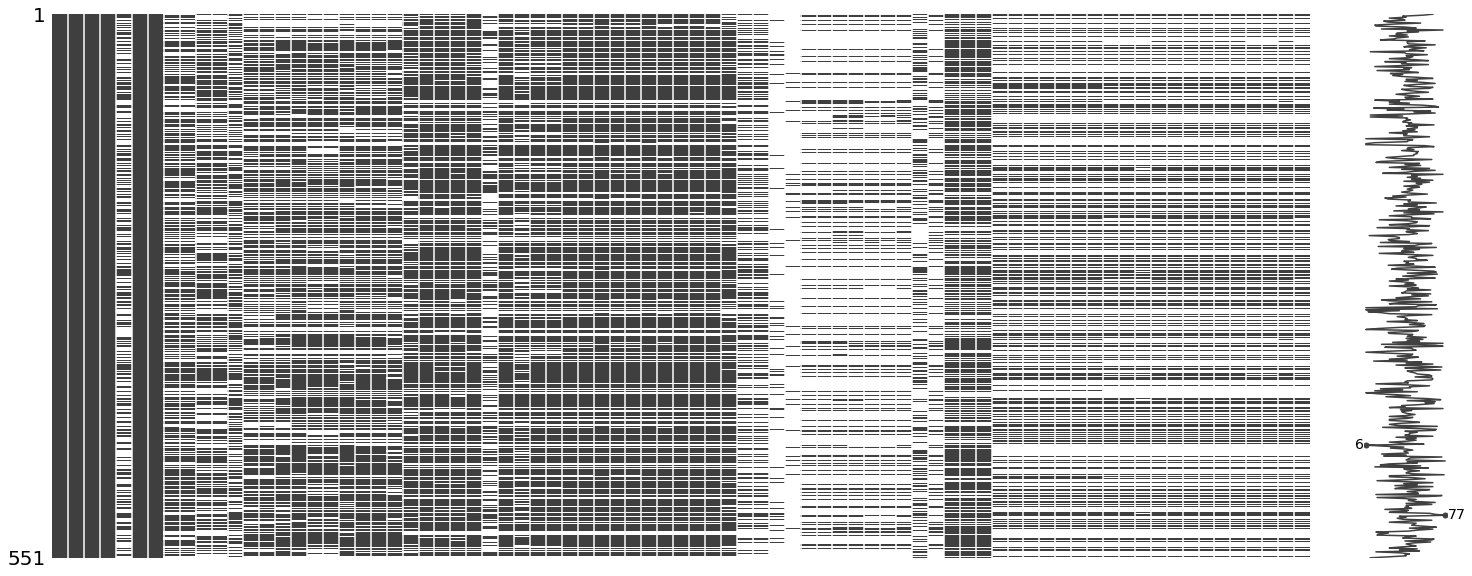

In [154]:
msno.matrix(ascvd_table_copy)

In [155]:
ascvd_table_copy.shape

(551, 79)

In [156]:
# non fragili e resilienti
ascvd_table_copy[(ascvd_table_copy['FrailtyPhenotypeBool'] == False) & (ascvd_table_copy['Resilience'] >= 75.7)].shape

(27, 79)

In [157]:
# non fragili e non resilienti
ascvd_table_copy[(ascvd_table_copy['FrailtyPhenotypeBool'] == False) & (ascvd_table_copy['Resilience'] < 75.7)].shape

(125, 79)

In [158]:
# Fragili e resilienti
ascvd_table_copy[(ascvd_table_copy['FrailtyPhenotypeBool'] == True) & (ascvd_table_copy['Resilience'] >= 75.7)].shape

(2, 79)

In [159]:
# fragili e non resilienti
ascvd_table_copy[(ascvd_table_copy['FrailtyPhenotypeBool'] == True) & (ascvd_table_copy['Resilience'] < 75.7)].shape

(22, 79)

In [160]:
# tutti quelli con resilienza e fragilità non nulli
ascvd_table_copy[(ascvd_table_copy['FrailtyPhenotypeBool'].notna()) & (ascvd_table_copy['Resilience'].notna())].shape

(176, 79)

In [161]:
# i solo fragili/non fragili sono 300
ascvd_table_copy[ascvd_table_copy['FrailtyPhenotypeBool'].notna()].shape

(300, 79)

In [162]:
# tutti quelli col valore di resilience non nullo
ascvd_table_copy[ascvd_table_copy['Resilience'].notna()].shape

(207, 79)

In [164]:
# fragili e non resilienti = 0 (22)
ascvd_table_copy.loc[(ascvd_table_copy['FrailtyPhenotypeBool'].notna() & ascvd_table_copy['Resilience'].notna() & ascvd_table_copy['FrailtyPhenotypeBool'] == True) & (ascvd_table_copy['Resilience'] < 75.7), 'Outcome'] = 0

In [165]:
# non fragile e non resiliente = 1 (125)
ascvd_table_copy.loc[(ascvd_table_copy['FrailtyPhenotypeBool'].notna() & ascvd_table_copy['Resilience'].notna() & ascvd_table_copy['FrailtyPhenotypeBool'] == False) & (ascvd_table_copy['Resilience'] < 75.7), 'Outcome'] = 1

In [166]:
# fragile e resiliente = 2 (2)
ascvd_table_copy.loc[(ascvd_table_copy['FrailtyPhenotypeBool'].notna() & ascvd_table_copy['Resilience'].notna() & ascvd_table_copy['FrailtyPhenotypeBool'] == True) & (ascvd_table_copy['Resilience'] >= 75.7), 'Outcome'] = 2

In [167]:
# non fragile e resiliente = 3 (27)
ascvd_table_copy.loc[(ascvd_table_copy['FrailtyPhenotypeBool'].notna() & ascvd_table_copy['Resilience'].notna() & ascvd_table_copy['FrailtyPhenotypeBool'] == False) & (ascvd_table_copy['Resilience'] >= 75.7), 'Outcome'] = 3

In [168]:
ascvd_table_copy[ascvd_table_copy['Outcome'].notna()].shape

(207, 80)

In [ ]:
ascvd_table_copy.to_csv('TabellaFinale.csv')

In [ ]:
ascvd_table_copy.to_excel('TabellaFinale.xlsx')

In [ ]:
ascvd_table_copy['Outcome'].shape